In [1]:
import h5py as h5
import PreFRBLE
from PreFRBLE.likelihood import *
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

Simulations show that at $z \gtrsim 1.5$ about 90 % of baryons were contained in the IGM (Meiskin 2008, 0711.3358). Here we check how much results for a linear evolution of $f_{\rm IGM}$ between redshifts $z=1.5$ and $z=0$ (solid) would differ from constant $f_{\rm IGM}$ (dotted). The right plot shows the ratio of the two graphs.

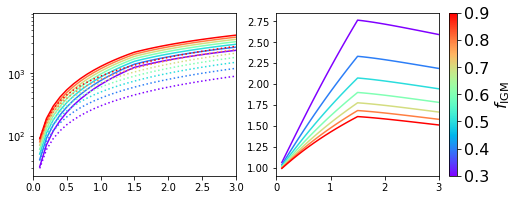

In [102]:

zs = np.linspace(0.1,6,60)
ps = np.arange(0.5,1.1,0.1)[::2]
p = 1
f_IGM0s = np.arange( 0.3,1.0,0.1 )

fig, axs = plt.subplots(1,2, figsize=(8,3))

for f_IGM0, color in zip( f_IGM0s, Rainbow(f_IGM0s) ):
    f_IGMs = f_IGM0 + np.where( zs<1.5, zs, 1.5)/1.5 * 0.50
    DMs = [ DM(z, f_IGM=f_IGM) for z, f_IGM in zip( zs, f_IGMs ) ]
    axs[1].plot(zs, DMs/(zs*1000*f_IGM0), color=color)
    axs[0].plot(zs, DMs, color=color)
    axs[0].plot( zs, zs*1000*f_IGM0, color=color, linestyle=":")
for ax in axs:
    ax.set_xlim(0,3)
axs[0].set_yscale('log')
Colorbar( f_IGM0s, label=r"$f_{\rm IGM}$" )


#### wipe all entries of a scenario

In [20]:
from time import sleep
import h5py as h5

scenario={ 
    'IGM':['alpha1-3rd_C300'], 
    'Host':['Rodrigues18'], 
    'Local':['Piro18/wind'] 
}

KeyFull( measure='RM', axis='', redshift=1., **scenario )


with h5.File( '/hummel/PreFRBLE/likelihood/observables_likelihood_Full.h5' ) as f:
#    for B in [1,2,3,4,5,6,7,8,9]: 
    f.__delitem__( "/alpha2-3rd_C300/Rodrigues18/Piro18/wind/1.3/RM" )
    for B in [2,6]: 
        for F in [3,4,5,6,7,8,9]: 
            tmp = scenario.copy()
            tmp['IGM'] = ['alpha{0}-3rd_C{1}00'.format(B,F)], 
            for z in redshift_bins: 
                key = KeyFull( measure='RM', axis='', redshift=z, **tmp )
                print( f[key] )
                try:
                    print( f[key].keys(), end=' ' )
                    print( key )
#                    f.__delitem__( key )
                except:
                    pass
                sleep(5e-3)

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/ipykernel_launcher.py:13: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  del sys.path[0]


KeyError: "Couldn't delete link (bad symbol table node signature)"

#### Recover HDF5 file with broken nodes

In [1]:
file_broken = '/hummel/PreFRBLE/likelihood/observables_likelihood_Full.h5'
file_recover = '/hummel/PreFRBLE/likelihood/observables_likelihood_Full_recover.h5'

import h5py as h5

def RecoverFile( f1, f2 ):
    """  recover read-open HDF5 file f1 to write-open HDF5 file f2  """
    names = []
    f1.visit(names.append)
    for n in names:
        try:
            f2.create_dataset( n, data=f1[n][()] )
        except:
            pass

        

In [ ]:
with h5.File( file_broken, 'r' ) as fb:
    with h5.File( file_recover, 'w' ) as fr:
        for key in fb.keys():
            try:
                fr.create_group(key)
                RecoverFile( fb[key], fr[key] )
            except:
                fr.__delitem__(key)
        
        

In [ ]:
VisitFile(file_broken)

In [12]:
def VisitFile( filename ):
    """ print keys and shape for all array datasets in hdf5-file """
    with h5.File(filename, 'r') as f:
        print(f.keys())
        names = []
        f.visit(names.append)
        for n in names:
            try: print(n, f[n][()].shape)
            except: pass

### test Convolution

/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


0.9999999999999999


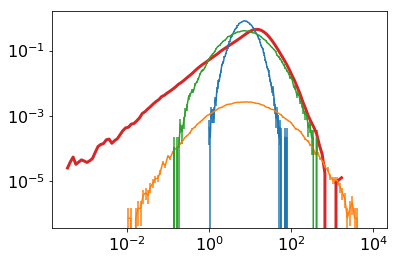

In [48]:
N = 100000 ## sample size
bins = 100
absolute=True
norm=0.01

## ranges for dummy functions
f = np.array([0,2]) 
g = np.array([-2,4])
h = np.array([-1,3])


## sample log-normal distribution
fs = np.random.lognormal( mean=2*np.mean(f), sigma=np.std(f)/2, size=N )
gs = np.random.lognormal( mean=2*np.mean(g), sigma=np.std(g)/2, size=N )
hs = np.random.lognormal( mean=2*np.mean(h), sigma=np.std(h)/2, size=N )

## likelihood function and deviation of samples f & g
P_f = Likelihood( fs, log=True, density=True, range=10.**f, bins=bins )
P_f = list(P_f)
P_f.append( LikelihoodDeviation( *P_f, N=N ) )

P_g = Likelihood( gs, log=True, density=True, range=10.**g, bins=bins )
P_g = list(P_g)
P_g.append( LikelihoodDeviation( *P_g, N=N ) )

P_h = Likelihood( hs, log=True, density=True, range=10.**h, bins=bins )
P_h = list(P_h)
P_h.append( LikelihoodDeviation( *P_h, N=N ) )


P_g[0] *= norm




P_con = LikelihoodsConvolve( P_f, P_g, P_h , log=True, absolute=absolute, N=N, smooth=True )
print(LikelihoodNorm(*P_con))
fig, ax = plt.subplots()

PlotLikelihood( *P_f , density=True, ax=ax)
PlotLikelihood( *P_g , density=True, ax=ax)
PlotLikelihood( *P_h , density=True, ax=ax)
PlotLikelihood( *P_con[:-1] , density=True, ax=ax, lw=3, cumulative=0)


/data/PreFRBLE/venv_PreFRBLE/lib/python3.4/site-packages/PreFRBLE/likelihood.py:66: RuntimeWarning: divide by zero encountered in power
  res =  ( P*np.diff(x)*N )**-0.5


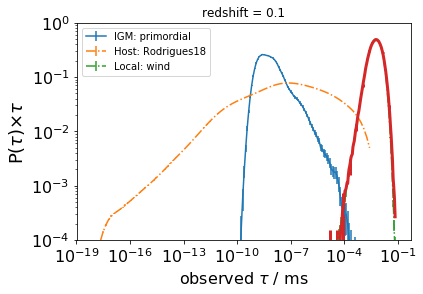

In [20]:
import h5py as h5
import PreFRBLE
from PreFRBLE.likelihood import *
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

scenario = {
    'IGM' : ['primordial'],
    'Host' : ['Rodrigues18'],
#    'Inter' : ['Rodrigues18'],
    'Local' : ['Piro18/wind'],
#    'N_inter' : True
}

measure = 'tau'
redshift = 0.1

fig, ax = plt.subplots()

PlotContributions( dev=True, measure=measure, redshift=redshift, ax=ax, **scenario )
P = LikelihoodFull( dev=True, measure=measure, redshift=redshift, progress_bar=True, **scenario)
PlotLikelihood( *P, ax=ax, lw=3, errorevery=10 )

ax.set_ylim(1e-4,1)
plt.show()